<a href="https://colab.research.google.com/github/StrizhAXE/ML_in_busyness/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

Информация о наборе данных:

Все данные взяты из одного непрерывного измерения ЭЭГ с помощью нейрогарнитуры Emotiv EEG. Продолжительность измерения составила 117 секунд. Состояние глаз регистрировалось камерой во время измерения ЭЭГ и добавлялось позже вручную в файл после анализа видеокадров. «1» указывает на закрытые глаза, а «0» - на открытые. Все значения расположены в хронологическом порядке с первым измеренным значением вверху данных. 

### 1. Feature importance признаков

In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

path = 'd:\\GeekBrains\\Q4\\ML_in_busyness\\Datasets\\EEG\\'

In [3]:
df = pd.read_csv(path+"EEG Eye State.csv")
features = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
print(df.shape)
df.sample(3)

(14980, 15)


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
11667,4293.85,4024.10,4260.00,4122.05,4348.21,4631.79,4077.95,4611.28,4200.51,4226.15,4196.41,4261.03,4585.13,4354.87,1
11025,4309.23,4022.05,4268.21,4123.08,4350.26,4635.38,4077.44,4630.77,4211.79,4242.56,4197.95,4289.74,4614.87,4383.59,0
1220,4296.92,4034.36,4263.08,4139.49,4329.23,4577.44,4069.23,4589.74,4182.05,4222.56,4172.31,4278.46,4600.51,4353.33,0


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['eyeDetection'], random_state=13)

In [5]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

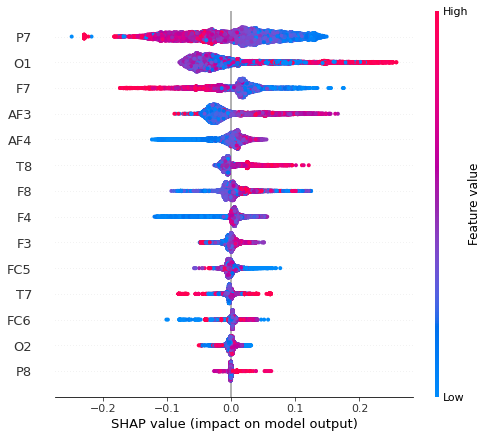

In [6]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- Чем меньше P7 и F7, тем больше вероятность что глаза открыты
- Чем меньше O1 и AF3, тем больше вероятность что глаза закрыты

Можно даже просто взять средние значения SHAP для каждого признака

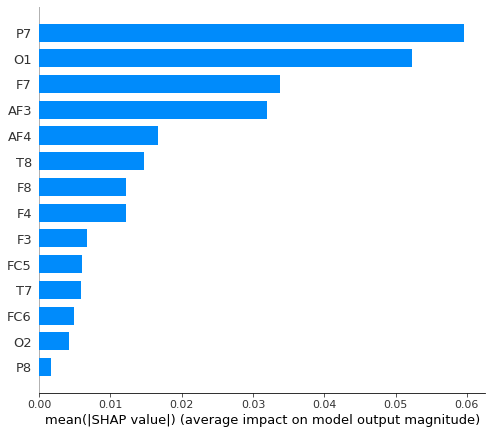

In [7]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [8]:
feature_important = model.get_score(importance_type='weight')
dict_sorted = dict(sorted(feature_important.items(), key=lambda item: item[1], reverse=True))
sorted_df = pd.DataFrame(pd.Series(dict_sorted))
top_feature = sorted_df.head(10).index
top_feature

Index(['P7', 'O1', 'F7', 'AF3', 'F8', 'FC5', 'AF4', 'FC6', 'F3', 'F4'], dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[top_feature], df['eyeDetection'], random_state=13)

In [10]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:500:], X_train.iloc[:500:])

Наиболее важными фичами(признаками) являются F7, O1, P7 и AF3

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value